In [1]:
from  scipy.special import j1
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 1631

snap_info=Snap_Info()

# The relation of number density and halo min mass

In [2]:
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm

In [3]:
np.std(halov), np.log10(np.max(halo_mass))

(245.9673695366799, 14.47040635687773)

39801958
23465096
13517202
7539729
4079592
2125719
1057642
498261
224045
88401


Text(0, 0.5, 'n [h/Mpc]^3')

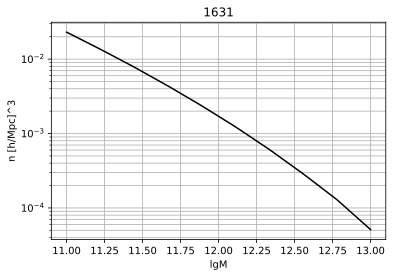

In [14]:
fig, ax = plt.subplots()
lgM_min = np.linspace(11, 13, 10)
n = np.zeros(len(lgM_min))
for i in range(len(lgM_min)):
    label = np.where((halo_mass>10**lgM_min[i]))[0]
    N = len(label)
    print(N)
    n[i] = N/Boxlen**3
    
ax.plot(lgM_min, n, 'k')
    
ax.set_yscale("log")
ax.grid(which="both")
ax.set_title(str(Snapshot))
ax.set_xlabel("lgM")
ax.set_ylabel("n [h/Mpc]^3")

In [16]:
f = interp1d(n, lgM_min)
for i in range(1, 10):
    print(i, f(i*10**-4))
for i in range(1, 10):
    print(i, f(i*10**-3))

1 12.861731198332892
2 12.679270680372003
3 12.547555045467917
4 12.47890773710385
5 12.410260428739784
6 12.341613120375717
7 12.301717219097709
8 12.265764754996336
9 12.229812290894966
1 12.193859826793595
2 11.959812638794846
3 11.817959905441123
4 11.706981640707674
5 11.625762313494905
6 11.56152111993368
7 11.497279926372455
8 11.437591000556388
9 11.398989865481969


In [7]:
from kSZ_forecast_general_func import *

Grid = 512
redshift_bin = 2
den_method = 0   #NGP
vel_method = 0   #thetap
HOD_input = "0"
HOD_random_seed = 100

CMB_survey = "ACT"
MAS = "NGP"
the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

if redshift_bin == 0:
    Snapshot = 2448
    n_gal = np.array([4, 4.4, 4.8])*10**-4
    HOD_model = "DESI"
    gll = [0,1,2]
    rr = "0.6 < z < 1"
    z_eff = 0.8
if redshift_bin == 1:
    Snapshot = 2448
    n_gal = np.array([6, 6.6, 7.2])*10**-4
    HOD_model = "HSC_NB816"
    gll = [0,1,2]
    rr = "1 < z < 1.6"
    z_eff = 1.3
if redshift_bin == 2:
    Snapshot = 1631
    n_gal = np.array([3, 3.3, 3.6])*10**-4
    HOD_model = "HSC_NB912"
    gll = [0,1,2]
    rr = "1.6 < z < 2.4"
    z_eff = 2.0
if not HOD_input=="0":
    HOD_model = HOD_input


Thelen = Boxlen/h/cosmo.comoving_distance(z=z_eff).value
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+z_eff)**2/h  # proj mom: km/h -> dkSZ/CMB

print("read DEN, MOM")
Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm

print("read halo")
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm

haloxx_rsd=add_RSD(halox*Boxlen,halov*(1+snap_info.get_redshift(Snapshot)), n_rsd, cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h

pkden,kden=fa.CalPS(denp,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
velp = momden2vel(denp, momp)
thetap = vel2theta(velp, Boxlen)

for i in [0,1,2]:
    # =========== galaxy mock sample ==============
    galaxy_number_density_label = i
    #halo sample for velocity reconstruction(for HOD_method)
    if HOD_model == "DESI":
        richness = np.zeros(len(halo_mass), dtype = np.int32)
        for i in range(4):
            HOD_model = "DESI_L"+str(i)
            d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
            N_cen = d["N_cen"]
            N_sat = d["N_sat"]
            richness+=(N_cen + N_sat)
    else:
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness = N_cen + N_sat
    N_gal = np.sum(richness)
    print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
    galaxy_pos_all = np.zeros((N_gal, 3))
    for i in range(3):
        galaxy_pos_all[:,i]=np.repeat(haloxx_rsd[:,i], richness)

    #rand to make density (for n_gal)
    N_gal_need = np.int32(n_gal[galaxy_number_density_label]*Boxlen**3)
    a = np.arange(N_gal, dtype=np.int32)
    np.random.shuffle(a)
    galaxy_pos = galaxy_pos_all[list(a[:N_gal_need]),:]
    N_gal = len(galaxy_pos[:,0])
    print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
    #===============================================


    #========== reconstruct kSZ tamplate ===========
    deng_rsd=den_NGP(galaxy_pos_all,Grid)
    W,kx,ky,kz=wiener_filter_theta_esti(deng_rsd,thetap, Boxlen)
    #del thetap
    thetag_rsd_rec=wiener_filter_den2theta(deng_rsd,W,kx,ky,kz, Boxlen)
    #del W,kx,ky,kz
    velg_rsd_rec=theta2vel(thetag_rsd_rec, Boxlen)


    pk_gal,k_gal=fa.CalPS(deng_rsd,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
    print(k_gal,(pk_gal-1/n_gal[galaxy_number_density_label])/pkden)
    break

read DEN, MOM
read halo
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 518400    n= 0.0003
[0.009069   0.0128255  0.01570796 0.0187783  0.02354638 0.02965167
 0.03764974 0.04741486 0.05968261 0.07532158 0.09476186 0.11916417
 0.14988154 0.1885965  0.23746561 0.29902589 0.37647414 0.47388253
 0.59653645 0.75102431 0.94550382 1.19029842 1.47397064 1.79764632
 2.1428839 ] [   8.85701016    8.09984216    8.87753942    8.27140256    8.71445526
    8.64134453    8.89248789    8.26864732    8.25111894    7.89384466
    7.35203238    6.71933478    5.53810759    3.79186745    0.85674917
   -3.92381503  -11.61779618  -24.01120708  -43.77866429  -74.95962023
 -122.98013966 -189.66115908 -270.14837627 -374.34846856 -482.25093602]


In [8]:
print(k_gal,np.sqrt((pk_gal-1/n_gal[galaxy_number_density_label])/pkden), (pk_gal)/pkden)

[0.009069   0.0128255  0.01570796 0.0187783  0.02354638 0.02965167
 0.03764974 0.04741486 0.05968261 0.07532158 0.09476186 0.11916417
 0.14988154 0.1885965  0.23746561 0.29902589 0.37647414 0.47388253
 0.59653645 0.75102431 0.94550382 1.19029842 1.47397064 1.79764632
 2.1428839 ] [2.97607294 2.84602216 2.97952    2.87600462 2.95202562 2.93961639
 2.98202748 2.87552557 2.8724761  2.80959867 2.71146314 2.59216797
 2.35331842 1.9472718  0.92560746        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan] [  9.84363438   8.90422577   9.49449785   8.76411047   9.38847261
   9.47062035   9.85206969   9.53679647   9.7157553    9.84798891
  10.22522453  10.47225205  11.11901458  11.78904628  12.96402709
  14.36574715  16.19363615  18.6182267   22.15678053  27.75088455
  37.12227163  51.21876161  69.64629675  94.88191337 122.20049086]


/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
